In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# imports
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Video pipeline

In [ ]:
def video_to_frames(video_path, output_folder=None, return_frames=True):
    """
    Converts a video file to an array of image frames.

    Parameters:
    - video_path: Path to the input video file
    - output_folder: Optional folder to save the extracted frames as image files
    - return_frames: Whether to return the frames as a numpy array

    Returns:
    - frames: List of numpy arrays representing each frame (if return_frames=True)
    """

    if not os.path.isfile(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    if output_folder is not None and not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise Exception(f"Error opening video file: {video_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video properties: {width}x{height}, {fps} fps, {frame_count} frames")

    frames = [] if return_frames else None

    for i in tqdm(range(frame_count), desc="Processing frames"):
        ret, frame = cap.read()

        if not ret:
            print(f"Warning: Could only read {i} frames out of {frame_count}")
            break

        if return_frames:
            frames.append(frame)

        if output_folder is not None:
            frame_filename = os.path.join(output_folder, f"frame_{i:06d}.jpg")
            cv2.imwrite(frame_filename, frame)

    cap.release()

    return frames

def frames_to_video(frames, output_path, fps=30, codec='mp4v'):
    """
    Converts an array of image frames to a video file.

    Parameters:
    - frames: List or array of numpy arrays representing each frame
    - output_path: Path to save the output video
    - fps: Frames per second for the output video
    - codec: FourCC codec code (default: mp4v for .mp4 files)

    Returns:
    - output_path: Path to the saved video file
    """
    if not frames:
        raise ValueError("No frames provided")

    height, width = frames[0].shape[:2]

    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in tqdm(frames, desc="Writing video"):
        out.write(frame)

    out.release()

    print(f"Video saved to {output_path}")
    return output_path

# function to create video from a folder of images
def images_to_video(image_folder, output_path, fps=30, codec='mp4v', pattern="frame_*.jpg"):
    """
    Converts a folder of images to a video file.

    Parameters:
    - image_folder: Path to the folder containing image files
    - output_path: Path to save the output video
    - fps: Frames per second for the output video
    - codec: FourCC codec code (default: mp4v for .mp4 files)
    - pattern: Glob pattern to match image files

    Returns:
    - output_path: Path to the saved video file
    """
    import glob

    image_files = sorted(glob.glob(os.path.join(image_folder, pattern)))

    if not image_files:
        raise ValueError(f"No images found in {image_folder} matching pattern {pattern}")

    first_image = cv2.imread(image_files[0])
    height, width = first_image.shape[:2]

    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for image_file in tqdm(image_files, desc="Writing video"):
        frame = cv2.imread(image_file)
        out.write(frame)

    out.release()

    print(f"Video saved to {output_path}")
    return output_path

# if __name__ == "__main__":
#     # Convert video to frames and back
#     video_path = "/content/vecteezy_the-footage-animation-of-countdown-timer-from-5-seconds_5148996 (1).mp4"
#     output_frames_folder = "sample_data"
#     output_video_path = "output_video.mp4"

#     # Extract frames from video
#     frames = video_to_frames(video_path, output_folder=output_frames_folder)

#     # Convert frames back to video
#     # frames_to_video(frames, output_video_path, fps=30)

#     # Example 2: Create video from folder of images
#     # images_to_video(output_frames_folder, "output_from_images.mp4", fps=30)

# YOLO

In [ ]:
!git clone https://github.com/abewley/sort.git

Cloning into 'sort'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 208 (delta 2), reused 1 (delta 1), pack-reused 203 (from 2)
Receiving objects: 100% (208/208), 1.21 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
import matplotlib

matplotlib.use('Agg')

import matplotlib.pyplot as plt

In [ ]:
!pip install filterpy
!pip install ultralytics
!pip install easyocr
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=0ee58af51ec4343250299b8359f3f0ebc4f1a2f09216f92cc837d800b9614a16
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 24.6 MB/s eta 0:00:00


In [ ]:
!pwd

/content


In [ ]:
matplotlib.use('Agg')

In [ ]:
# IMPORTANT: go into "sort" and go into sort.py and remove the line that says "matplotlib.use('TkAgg')"

In [ ]:
import sys
sys.path.append("./sort")
from sort import *

In [ ]:
from ultralytics import YOLO
import easyocr

In [ ]:
import os
print(os.listdir("/content/sort"))

['__pycache__', '.gitignore', 'requirements.txt', 'data', 'LICENSE', '.git', 'README.md', 'sort.py']


In [ ]:
import importlib.util
import torch
spec = importlib.util.spec_from_file_location("sort", "/content/sort/sort.py")
sort_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sort_module)

Sort = sort_module.Sort  # Access the Sort class
# Load YOLOv8 model
# Add GPU support
model = YOLO('yolov8n.pt').to('cuda' if torch.cuda.is_available() else 'cpu')  # or 'yolov8n.pt' for smaller/faster model
reader = easyocr.Reader(['en'])

100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists")

def process_frames_with_tracking(input_folder, output_video, max_frames=60):
    """
    Process frames with YOLOv8 to detect people, track them across frames,
    and create a video with assigned IDs.

    Parameters:
    - input_folder: Folder containing the input frames
    - output_video: Path to save the output video
    - max_frames: Maximum number of frames to process
    """

    # Initialize SORT tracker
    tracker = Sort()

    # Get frame files
    frame_files = sorted([f for f in os.listdir(input_folder) if f.startswith("frame_")])[:max_frames]
    if not frame_files:
        raise ValueError(f"No frames found in {input_folder}")

    processed_frames = []

    for frame_file in tqdm(frame_files, desc="Processing frames with YOLOv8 and tracking"):
        frame_path = os.path.join(input_folder, frame_file)
        image = cv2.imread(frame_path)
        if image is None:
            print(f"Warning: Could not read {frame_path}")
            continue

        # Run YOLOv8 inference
        results = model(image, conf=0.5)  # Increased confidence threshold for tracking

        # Process detections
        detections = []

        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Get box coordinates, confidence, and class
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cls = int(box.cls[0])

                # Check if detection is person (class 0 in COCO)
                if cls == 0:  # person class
                    # Format detection for SORT: [x1, y1, x2, y2, confidence]
                    detections.append([x1, y1, x2, y2, conf])

        # Convert detections to NumPy array
        if len(detections) > 0:
            detections = np.array(detections)
        else:
            detections = np.empty((0, 5))

        # Update tracker
        tracked_objects = tracker.update(detections)

        # Draw tracking results
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id = obj.astype(int)

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Draw ID and try to detect jersey number in this region
            cv2.putText(image, f"ID: {track_id}", (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Optional: Extract ROI for jersey number detection
            roi = image[y1:y2, x1:x2]
            if roi.size > 0:  # Check if ROI is valid
                # Convert to grayscale for better number detection
                gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                # Apply thresholding to isolate numbers
                _, thresh = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

                # Try to detect numbers using EasyOCR

                results = reader.readtext(
                    thresh,
                    allowlist='0123456789',
                    paragraph=False,
                    min_size=20,
                    width_ths=0.5
                )

                # If numbers are detected, display them
                for (bbox, text, prob) in results:
                    if text.isdigit() and prob > 0.5:
                        cv2.putText(image, f"#{text}", (x1, y2 + 20),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
                        break  # Only show first detected number

        # Add processed frame to list
        processed_frames.append(image)

    # Create video from processed frames
    if processed_frames:
        print(f"Creating video from {len(processed_frames)} processed frames...")
        frames_to_video(processed_frames, output_video, fps=30)
        print(f"Video saved to {output_video}")
    else:
        print("No frames were processed successfully.")

import os
import cv2
import numpy as np
from tqdm import tqdm

def process_frames_with_bounding_boxes(input_folder, output_video, max_frames=60):
    """
    Process frames with YOLOv8 to detect people, draw bounding boxes,
    and create a video from the processed frames.

    Parameters:
    - input_folder: Folder containing the input frames
    - output_video: Path to save the output video
    - max_frames: Maximum number of frames to process
    """
    # Load YOLOv8 model
    model = YOLO('yolov8s.pt')  # or 'yolov8n.pt' for smaller/faster model

    # Get frame files
    frame_files = sorted([f for f in os.listdir(input_folder) if f.startswith("frame_")])[:max_frames]
    if not frame_files:
        raise ValueError(f"No frames found in {input_folder}")

    processed_frames = []

    for frame_file in tqdm(frame_files, desc="Processing frames with YOLOv8"):
        # Load the image
        frame_path = os.path.join(input_folder, frame_file)
        image = cv2.imread(frame_path)
        if image is None:
            print(f"Warning: Could not read {frame_path}")
            continue

        # Run YOLOv8 inference
        results = model(image, conf=0.15)  # confidence threshold 0.25

        # Process detections
        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Get box coordinates and confidence
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cls = int(box.cls[0])

                # Check if detection is person (class 0 in COCO)
                if cls == 0:  # person class
                    # Draw bounding box
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, f"Person: {conf:.2f}", (x1, y1 - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Add the processed frame to our list
        processed_frames.append(image)

    # Create video from processed frames
    if processed_frames:
        print(f"Creating video from {len(processed_frames)} processed frames...")
        frames_to_video(processed_frames, output_video, fps=30)
        print(f"Video saved to {output_video}")
    else:
        print("No frames were processed successfully.")



if __name__ == "__main__":
    video_path = "/content/drive/My Drive/CS131 Final Proj/nba_clip2.mov"
    frames_path = "/content/drive/My Drive/CS131 Final Proj/Test Frames Video 1"
    # Process the first 60 frames and create a video
    #process_frames_with_bounding_boxes(frames_path, video_path, max_frames=60)
    process_frames_with_tracking(frames_path, video_path, max_frames=60)

Processing frames with YOLOv8 and tracking:   0%|          | 0/60 [00:00<?, ?it/s]


0: 384x640 7 persons, 73.6ms
Speed: 15.0ms preprocess, 73.6ms inference, 402.1ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   2%|▏         | 1/60 [00:02<02:50,  2.88s/it]


0: 384x640 7 persons, 10.5ms
Speed: 3.6ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   3%|▎         | 2/60 [00:03<01:45,  1.82s/it]


0: 384x640 10 persons, 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   5%|▌         | 3/60 [00:04<01:14,  1.30s/it]


0: 384x640 10 persons, 15.5ms
Speed: 3.5ms preprocess, 15.5ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   7%|▋         | 4/60 [00:06<01:22,  1.47s/it]


0: 384x640 10 persons, 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   8%|▊         | 5/60 [00:09<01:50,  2.01s/it]


0: 384x640 10 persons, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  10%|█         | 6/60 [00:09<01:16,  1.41s/it]


0: 384x640 9 persons, 13.5ms
Speed: 3.3ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  12%|█▏        | 7/60 [00:09<00:53,  1.02s/it]


0: 384x640 9 persons, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  13%|█▎        | 8/60 [00:10<00:39,  1.31it/s]


0: 384x640 9 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  15%|█▌        | 9/60 [00:10<00:30,  1.69it/s]


0: 384x640 9 persons, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  17%|█▋        | 10/60 [00:10<00:23,  2.17it/s]


0: 384x640 10 persons, 12.1ms
Speed: 3.5ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  18%|█▊        | 11/60 [00:10<00:18,  2.68it/s]


0: 384x640 10 persons, 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  20%|██        | 12/60 [00:10<00:15,  3.20it/s]


0: 384x640 10 persons, 12.9ms
Speed: 3.6ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  22%|██▏       | 13/60 [00:10<00:12,  3.72it/s]


0: 384x640 9 persons, 14.7ms
Speed: 3.5ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  23%|██▎       | 14/60 [00:11<00:14,  3.22it/s]


0: 384x640 10 persons, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  25%|██▌       | 15/60 [00:11<00:12,  3.68it/s]


0: 384x640 10 persons, 11.9ms
Speed: 3.3ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  27%|██▋       | 16/60 [00:11<00:11,  3.97it/s]


0: 384x640 10 persons, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  28%|██▊       | 17/60 [00:11<00:09,  4.52it/s]


0: 384x640 10 persons, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  30%|███       | 18/60 [00:11<00:08,  5.09it/s]


0: 384x640 11 persons, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  32%|███▏      | 19/60 [00:12<00:07,  5.38it/s]


0: 384x640 11 persons, 9.5ms
Speed: 3.7ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  33%|███▎      | 20/60 [00:12<00:07,  5.28it/s]


0: 384x640 8 persons, 12.1ms
Speed: 4.4ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  35%|███▌      | 21/60 [00:12<00:06,  5.61it/s]


0: 384x640 8 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  37%|███▋      | 22/60 [00:12<00:06,  6.01it/s]


0: 384x640 11 persons, 6.9ms
Speed: 3.5ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  38%|███▊      | 23/60 [00:12<00:05,  6.44it/s]


0: 384x640 11 persons, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  40%|████      | 24/60 [00:12<00:05,  6.75it/s]


0: 384x640 11 persons, 7.0ms
Speed: 3.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  42%|████▏     | 25/60 [00:13<00:05,  6.94it/s]


0: 384x640 11 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  43%|████▎     | 26/60 [00:13<00:05,  6.23it/s]


0: 384x640 10 persons, 13.5ms
Speed: 4.2ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  45%|████▌     | 27/60 [00:13<00:05,  6.24it/s]


0: 384x640 10 persons, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  47%|████▋     | 28/60 [00:13<00:05,  5.99it/s]


0: 384x640 11 persons, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  48%|████▊     | 29/60 [00:13<00:05,  6.10it/s]


0: 384x640 11 persons, 7.0ms
Speed: 3.2ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  50%|█████     | 30/60 [00:13<00:04,  6.24it/s]


0: 384x640 10 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  52%|█████▏    | 31/60 [00:14<00:04,  6.37it/s]


0: 384x640 10 persons, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  53%|█████▎    | 32/60 [00:14<00:05,  5.60it/s]


0: 384x640 12 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  55%|█████▌    | 33/60 [00:14<00:04,  5.78it/s]


0: 384x640 12 persons, 7.2ms
Speed: 3.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  57%|█████▋    | 34/60 [00:14<00:04,  5.63it/s]


0: 384x640 11 persons, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  58%|█████▊    | 35/60 [00:14<00:04,  5.86it/s]


0: 384x640 11 persons, 6.7ms
Speed: 3.3ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  60%|██████    | 36/60 [00:14<00:04,  5.86it/s]


0: 384x640 11 persons, 7.2ms
Speed: 3.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  62%|██████▏   | 37/60 [00:15<00:03,  5.93it/s]


0: 384x640 11 persons, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  63%|██████▎   | 38/60 [00:15<00:03,  6.11it/s]


0: 384x640 11 persons, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  65%|██████▌   | 39/60 [00:15<00:03,  6.25it/s]


0: 384x640 11 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  67%|██████▋   | 40/60 [00:15<00:03,  6.08it/s]


0: 384x640 12 persons, 6.8ms
Speed: 3.5ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  68%|██████▊   | 41/60 [00:15<00:03,  6.20it/s]


0: 384x640 12 persons, 6.7ms
Speed: 3.3ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  70%|███████   | 42/60 [00:15<00:02,  6.23it/s]


0: 384x640 11 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  72%|███████▏  | 43/60 [00:16<00:02,  6.37it/s]


0: 384x640 11 persons, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  73%|███████▎  | 44/60 [00:16<00:02,  6.22it/s]


0: 384x640 9 persons, 7.1ms
Speed: 3.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  75%|███████▌  | 45/60 [00:16<00:02,  6.32it/s]


0: 384x640 9 persons, 6.8ms
Speed: 3.4ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  77%|███████▋  | 46/60 [00:16<00:02,  6.62it/s]


0: 384x640 11 persons, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  78%|███████▊  | 47/60 [00:16<00:01,  6.75it/s]


0: 384x640 10 persons, 14.2ms
Speed: 4.2ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  80%|████████  | 48/60 [00:16<00:01,  6.58it/s]


0: 384x640 10 persons, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  82%|████████▏ | 49/60 [00:16<00:01,  6.87it/s]


0: 384x640 10 persons, 7.1ms
Speed: 3.6ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  83%|████████▎ | 50/60 [00:17<00:01,  7.11it/s]


0: 384x640 11 persons, 10.3ms
Speed: 3.6ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  85%|████████▌ | 51/60 [00:17<00:01,  6.82it/s]


0: 384x640 10 persons, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  87%|████████▋ | 52/60 [00:17<00:01,  7.19it/s]


0: 384x640 11 persons, 7.0ms
Speed: 3.4ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  88%|████████▊ | 53/60 [00:17<00:00,  7.27it/s]


0: 384x640 11 persons, 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  90%|█████████ | 54/60 [00:17<00:00,  6.75it/s]


0: 384x640 8 persons, 7.0ms
Speed: 3.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  92%|█████████▏| 55/60 [00:17<00:00,  7.07it/s]


0: 384x640 8 persons, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  93%|█████████▎| 56/60 [00:17<00:00,  7.34it/s]


0: 384x640 6 persons, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  95%|█████████▌| 57/60 [00:18<00:00,  7.96it/s]


0: 384x640 6 persons, 6.9ms
Speed: 3.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  98%|█████████▊| 59/60 [00:18<00:00,  8.66it/s]


0: 384x640 7 persons, 7.2ms
Speed: 3.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking: 100%|██████████| 60/60 [00:18<00:00,  3.27it/s]

Creating video from 60 processed frames...



Writing video: 100%|██████████| 60/60 [00:01<00:00, 56.41it/s]

Video saved to /content/drive/My Drive/CS131 Final Proj/nba_clip2.mov
Video saved to /content/drive/My Drive/CS131 Final Proj/nba_clip2.mov


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

# Birds eye view

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def detect_court_lines(frame):
    """
    Detect basketball court lines to find the court corners.

    Args:
        frame: Input video frame

    Returns:
        Array of four corner points of the court
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate the edges to connect nearby edges
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Find lines using Hough transform
    lines = cv2.HoughLinesP(dilated_edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=50)

    if lines is None or len(lines) < 4:
        print("Not enough lines detected. Using default court rectangle.")
        h, w = frame.shape[:2]
        # Return default court rectangle
        return np.array([
            [int(w * 0.2), int(h * 0.15)],  # Top-left
            [int(w * 0.8), int(h * 0.15)],  # Top-right
            [int(w * 0.8), int(h * 0.85)],  # Bottom-right
            [int(w * 0.2), int(h * 0.85)]   # Bottom-left
        ], dtype=np.float32)

    # Filter lines by angle to get vertical and horizontal lines
    horizontal_lines = []
    vertical_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate line angle
        angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)

        # Horizontal lines (angle close to 0 or 180 degrees)
        if angle < 30 or angle > 150:
            horizontal_lines.append(line[0])
        # Vertical lines (angle close to 90 degrees)
        elif 60 < angle < 120:
            vertical_lines.append(line[0])

    # For visualization
    line_img = frame.copy()
    for line in horizontal_lines:
        x1, y1, x2, y2 = line
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for line in vertical_lines:
        x1, y1, x2, y2 = line
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    cv2.imwrite('detected_lines.jpg', line_img)

    # Find the outermost lines to get court boundaries
    if len(horizontal_lines) >= 2 and len(vertical_lines) >= 2:
        # Sort horizontal lines by y-coordinate
        horizontal_lines.sort(key=lambda line: (line[1] + line[3]) / 2)
        top_line = horizontal_lines[0]
        bottom_line = horizontal_lines[-1]

        # Sort vertical lines by x-coordinate
        vertical_lines.sort(key=lambda line: (line[0] + line[2]) / 2)
        left_line = vertical_lines[0]
        right_line = vertical_lines[-1]

        # Find intersections of the outermost lines to get the court corners
        top_left = line_intersection(top_line, left_line)
        top_right = line_intersection(top_line, right_line)
        bottom_right = line_intersection(bottom_line, right_line)
        bottom_left = line_intersection(bottom_line, left_line)

        corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

        # Verify corners are within image boundaries
        h, w = frame.shape[:2]
        valid_corners = True

        for corner in corners:
            if not (0 <= corner[0] < w and 0 <= corner[1] < h):
                valid_corners = False
                break

        if valid_corners:
            # Draw the detected corners for visualization
            corner_img = frame.copy()
            for corner in corners:
                cv2.circle(corner_img, (int(corner[0]), int(corner[1])), 5, (0, 0, 255), -1)
            cv2.imwrite('detected_corners.jpg', corner_img)

            return corners

    # If we couldn't find valid corners, use default
    print("Could not determine valid corners. Using default court rectangle.")
    h, w = frame.shape[:2]
    return np.array([
        [int(w * 0.2), int(h * 0.15)],  # Top-left
        [int(w * 0.8), int(h * 0.15)],  # Top-right
        [int(w * 0.8), int(h * 0.85)],  # Bottom-right
        [int(w * 0.2), int(h * 0.85)]   # Bottom-left
    ], dtype=np.float32)

def line_intersection(line1, line2):
    """
    Find the intersection point of two lines.

    Args:
        line1: First line [x1, y1, x2, y2]
        line2: Second line [x1, y1, x2, y2]

    Returns:
        Intersection point [x, y]
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Line 1 as a1x + b1y = c1
    a1 = y2 - y1
    b1 = x1 - x2
    c1 = a1 * x1 + b1 * y1

    # Line 2 as a2x + b2y = c2
    a2 = y4 - y3
    b2 = x3 - x4
    c2 = a2 * x3 + b2 * y3

    determinant = a1 * b2 - a2 * b1

    if determinant == 0:
        # Lines are parallel, return a point on line1
        return [x1, y1]

    x = (b2 * c1 - b1 * c2) / determinant
    y = (a1 * c2 - a2 * c1) / determinant

    return [x, y]

def create_birds_eye_view(frame):
    """
    Convert a basketball court frame to a birds-eye view with player positions mapped.

    Args:
        frame: The input video frame (numpy array)

    Returns:
        A birds-eye view visualization of the court with player positions
    """
    # Make a copy of the frame to work with
    img = frame.copy()
    h, w = img.shape[:2]

    # Step 1: Detect court corners
    court_corners = detect_court_lines(img)

    # Step 2: Define the destination points for the birds-eye view
    # Standard basketball court dimensions: 94 feet x 50 feet
    court_width = 500    # Width in pixels for our birds-eye view
    court_height = 940   # Height in pixels for our birds-eye view

    dst_points = np.array([
        [0, 0],
        [court_width, 0],
        [court_width, court_height],
        [0, court_height]
    ], dtype=np.float32)

    # Step 3: Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(court_corners, dst_points)

    # Step 4: Detect players using YOLO
    model = YOLO('yolov8n.pt')  # Load a pre-trained YOLO model
    results = model(img)

    # Filter for person class (class 0 in COCO dataset)
    boxes = []
    for result in results:
        detections = result.boxes
        for i, box in enumerate(detections):
            cls = int(box.cls.item())
            if cls == 0:  # Person class
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                boxes.append([int(x1), int(y1), int(x2), int(y2)])

    # Step 5: Get player positions (bottom center of bounding boxes)
    player_positions = []
    for box in boxes:
        x1, y1, x2, y2 = box
        # Bottom center point of the bounding box
        foot_position = [int((x1 + x2) / 2), y2]
        player_positions.append(foot_position)

    # Step 6: Create a birds-eye view
    court_img = np.ones((court_height, court_width, 3), dtype=np.uint8) * 255

    # Draw court lines (simplified)
    # Outer boundary
    cv2.rectangle(court_img, (0, 0), (court_width, court_height), (0, 0, 0), 2)

    # Half-court line
    cv2.line(court_img, (0, court_height // 2), (court_width, court_height // 2), (0, 0, 0), 2)

    # Center circle
    center_x, center_y = court_width // 2, court_height // 2
    cv2.circle(court_img, (center_x, center_y), 60, (0, 0, 0), 2)

    # Free throw circles and lines
    # Top
    cv2.circle(court_img, (center_x, int(court_height * 0.15)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.15)),
             (int(court_width * 0.75), int(court_height * 0.15)), (0, 0, 0), 2)

    # Bottom
    cv2.circle(court_img, (center_x, int(court_height * 0.85)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.85)),
             (int(court_width * 0.75), int(court_height * 0.85)), (0, 0, 0), 2)

    # Step 7: Transform player positions to birds-eye view coordinates
    birds_eye_positions = []
    for pos in player_positions:
        # Add a 1 for homogeneous coordinates
        pos_homogeneous = np.array([pos[0], pos[1], 1])

        # Apply perspective transformation
        transformed = M.dot(pos_homogeneous)

        # Normalize
        transformed = transformed / transformed[2]
        birds_eye_positions.append((int(transformed[0]), int(transformed[1])))

    # Step 8: Draw players on the birds-eye view
    for i, pos in enumerate(birds_eye_positions):
        # Skip players outside the court
        if (0 <= pos[0] < court_width and 0 <= pos[1] < court_height):
            # Draw as a circle
            cv2.circle(court_img, pos, 10, (255, 0, 0), -1)  # Blue circles for players

            # Add player number
            cv2.putText(court_img, str(i+1), pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Draw the original frame with detected players and court corners for reference
    for corner in court_corners:
        cv2.circle(img, (int(corner[0]), int(corner[1])), 5, (0, 255, 0), -1)

    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        foot_position = [int((x1 + x2) / 2), y2]
        cv2.circle(img, tuple(foot_position), 5, (0, 0, 255), -1)

    return img, court_img

In [ ]:
%matplotlib inline

Could not determine valid corners. Using default court rectangle.

0: 416x640 13 persons, 97.9ms
Speed: 3.5ms preprocess, 97.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


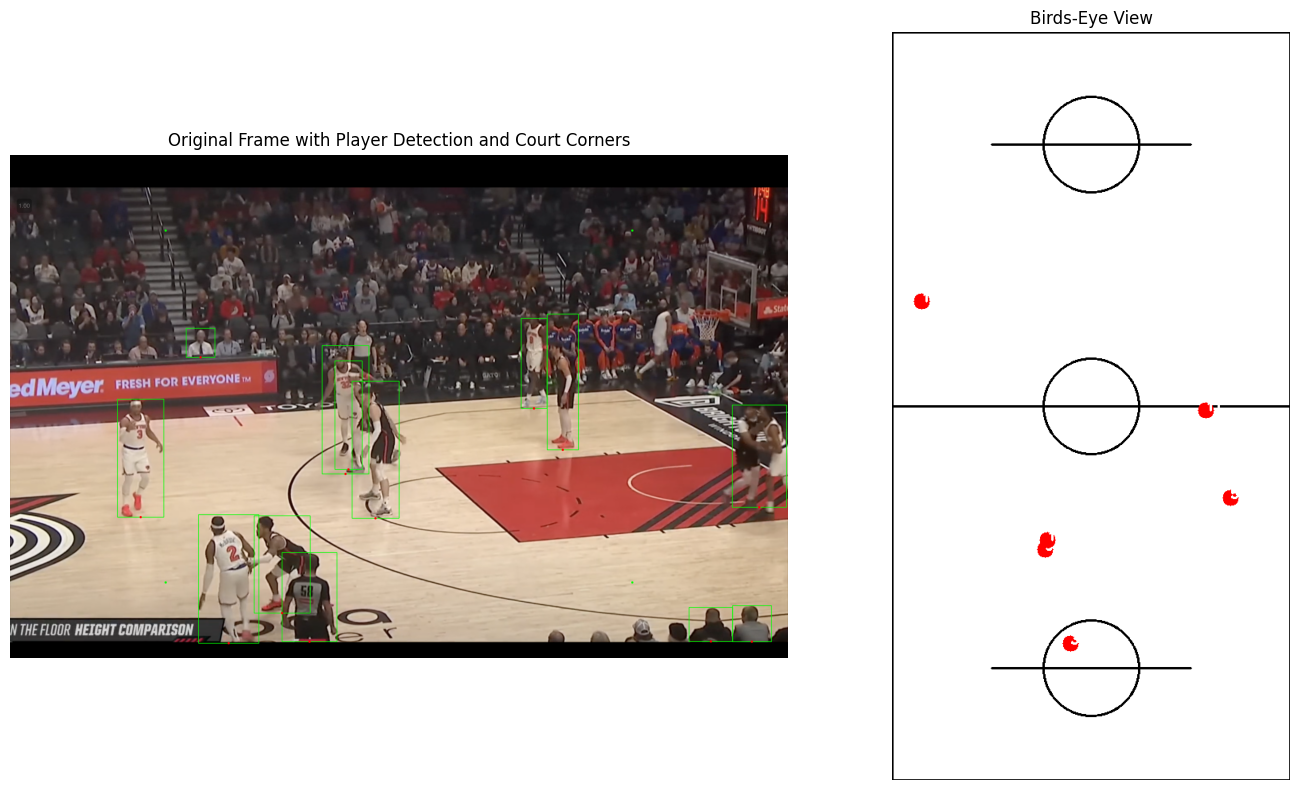

True

In [ ]:
# 1. Load a video frame
frame = cv2.imread('basketball_frame.png')

# 2. Process the frame
original_with_detection, birds_eye = create_birds_eye_view(frame)

# 3. Display results
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title('Original Frame with Player Detection and Court Corners')
plt.imshow(cv2.cvtColor(original_with_detection, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Birds-Eye View')
plt.imshow(birds_eye)
plt.axis('off')

plt.tight_layout()
plt.show()

# Save output images
cv2.imwrite('player_detection.jpg', original_with_detection)
cv2.imwrite('birds_eye_view.jpg', birds_eye)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## NEW CODE

In [43]:
import cv2
import numpy as np

# If you are using ultralytics YOLOv8:
from ultralytics import YOLO  # pip install ultralytics

# If you installed SORT from PyPI (sort-tracker):
from sort import Sort  # pip install sort-tracker

def track_objects_in_video(
    input_video_path: str,
    output_video_path: str,
    yolo_model_path: str = 'yolov8n.pt',
    confidence_threshold: float = 0.4,
):
    """
    Reads a video from `input_video_path`, runs YOLO detection frame-by-frame,
    tracks objects with SORT, draws bounding boxes and IDs, and writes an
    output video to `output_video_path`.
    """
    # ----------------------
    # 1. Initialize resources
    # ----------------------
    # Load YOLO model (change this if you have your own model or require special config)
    model = YOLO(yolo_model_path)

    # Initialize the SORT tracker
    tracker = Sort()  # optionally pass max_age, min_hits, etc. if needed

    # Open input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: could not open video {input_video_path}")
        return

    # Get frame dimensions & FPS
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)

    # Prepare video writer to save output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID', etc.
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_count = 0

    # ----------------------
    # 2. Process frames
    # ----------------------
    while True:
        ret, frame = cap.read()
        if not ret:
            # No more frames, or error
            break

        frame_count += 1
        # Optional: skip frames or do something else here

        # ----------------------
        # 2a. Perform YOLO detection
        # ----------------------
        # Run inference
        results = model.predict(frame, conf=confidence_threshold, verbose=False)
        # The 'results' object typically contains bounding boxes in xyxy format, conf, class, etc.

        # YOLOv8 returns results in a list. Let's get the first (and only) batch:
        bboxes = []
        if len(results) > 0:
            # results[0].boxes.boxes is a tensor of shape (N, 6) => [x1, y1, x2, y2, conf, class]
            detections = results[0].boxes.boxes
            for det in detections:
                x1, y1, x2, y2, conf, cls = det.tolist()
                # Only keep if confidence is above threshold (usually YOLO handles this)
                if conf >= confidence_threshold:
                    # SORT expects: [x1, y1, x2, y2, score]
                    bboxes.append([x1, y1, x2, y2, conf])

        # Convert to np.array for SORT
        bboxes = np.array(bboxes)

        # ----------------------
        # 2b. Pass detections to SORT to get tracked objects
        # ----------------------
        # tracked_objects is an array of shape (N, 5) => [x1, y1, x2, y2, track_id]
        tracked_objects = tracker.update(bboxes)

        # ----------------------
        # 2c. Draw bounding boxes and track IDs
        # ----------------------
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id = obj
            x1, y1, x2, y2, track_id = int(x1), int(y1), int(x2), int(y2), int(track_id)

            # Draw rectangle
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put track ID text above
            cv2.putText(frame, f"ID {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # ----------------------
        # 2d. Write the processed frame to output video
        # ----------------------
        out_video.write(frame)

    # ----------------------
    # 3. Cleanup
    # ----------------------
    cap.release()
    out_video.release()
    print("Tracking complete. Output saved to:", output_video_path)

In [44]:
input_path = "/content/drive/MyDrive/CS131 Final Proj/soccer_clip1.mov"
output_path = "soccer_output_tracked.mp4"
# Download a YOLOv8 model from ultralytics if you haven't already, or specify your own .pt path
yolo_weights = "yolov8n.pt"

track_objects_in_video(input_path, output_path, yolo_weights, confidence_threshold=0.4)

AttributeError: 'Boxes' object has no attribute 'boxes'. See valid attributes below.

    A class for managing and manipulating detection boxes.

    This class provides functionality for handling detection boxes, including their coordinates, confidence scores,
    class labels, and optional tracking IDs. It supports various box formats and offers methods for easy manipulation
    and conversion between different coordinate systems.

    Attributes:
        data (torch.Tensor | numpy.ndarray): The raw tensor containing detection boxes and associated data.
        orig_shape (Tuple[int, int]): The original image dimensions (height, width).
        is_track (bool): Indicates whether tracking IDs are included in the box data.
        xyxy (torch.Tensor | numpy.ndarray): Boxes in [x1, y1, x2, y2] format.
        conf (torch.Tensor | numpy.ndarray): Confidence scores for each box.
        cls (torch.Tensor | numpy.ndarray): Class labels for each box.
        id (torch.Tensor | None): Tracking IDs for each box (if available).
        xywh (torch.Tensor | numpy.ndarray): Boxes in [x, y, width, height] format.
        xyxyn (torch.Tensor | numpy.ndarray): Normalized [x1, y1, x2, y2] boxes relative to orig_shape.
        xywhn (torch.Tensor | numpy.ndarray): Normalized [x, y, width, height] boxes relative to orig_shape.

    Methods:
        cpu(): Returns a copy of the object with all tensors on CPU memory.
        numpy(): Returns a copy of the object with all tensors as numpy arrays.
        cuda(): Returns a copy of the object with all tensors on GPU memory.
        to(*args, **kwargs): Returns a copy of the object with tensors on specified device and dtype.

    Examples:
        >>> import torch
        >>> boxes_data = torch.tensor([[100, 50, 150, 100, 0.9, 0], [200, 150, 300, 250, 0.8, 1]])
        >>> orig_shape = (480, 640)  # height, width
        >>> boxes = Boxes(boxes_data, orig_shape)
        >>> print(boxes.xyxy)
        >>> print(boxes.conf)
        >>> print(boxes.cls)
        >>> print(boxes.xywhn)
    

## VIDEO GENERATION

In [45]:
# Convert video to frames and back
video_path = "/content/drive/MyDrive/CS131 Final Proj/soccer_clip1.mov"
output_frames_folder = "soccer_frames"
output_video_path = "soccer_output_video.mp4"

# Extract frames from video
frames = video_to_frames(video_path, output_folder=output_frames_folder)

Video properties: 2312x1180, 60.0 fps, 381 frames


Processing frames:  85%|████████▍ | 322/381 [00:21<00:03, 14.93it/s]

In [46]:
# Convert video to frames and back
video_path = "/content/drive/MyDrive/CS131 Final Proj/soccer_clip1.mov"
output_frames_folder = "/content/drive/MyDrive/CS131 Final Proj/Soccer Test Frames Video"
output_video_path = "soccer_output_video.mp4"

# Extract frames from video
frames = video_to_frames(video_path, output_folder=output_frames_folder)

Video properties: 2312x1180, 60.0 fps, 381 frames


Processing frames:  85%|████████▍ | 322/381 [00:22<00:04, 14.61it/s]

In [47]:
if __name__ == "__main__":
    video_path = "/content/drive/My Drive/CS131 Final Proj/soccer_demo_clip2.mov"
    frames_path = "/content/drive/My Drive/CS131 Final Proj/Soccer Test Frames Video"
    # Process the first 60 frames and create a video
    #process_frames_with_bounding_boxes(frames_path, video_path, max_frames=60)
    process_frames_with_tracking(frames_path, video_path, max_frames=60)

Processing frames with YOLOv8 and tracking:   0%|          | 0/60 [00:00<?, ?it/s]


0: 352x640 10 persons, 477.1ms
Speed: 18.4ms preprocess, 477.1ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:   2%|▏         | 1/60 [00:04<04:39,  4.74s/it]


0: 352x640 10 persons, 153.0ms
Speed: 4.2ms preprocess, 153.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:   3%|▎         | 2/60 [00:07<03:22,  3.49s/it]


0: 352x640 10 persons, 135.3ms
Speed: 3.9ms preprocess, 135.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:   5%|▌         | 3/60 [00:10<03:02,  3.19s/it]


0: 352x640 9 persons, 282.2ms
Speed: 5.7ms preprocess, 282.2ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:   7%|▋         | 4/60 [00:13<03:02,  3.26s/it]


0: 352x640 10 persons, 230.7ms
Speed: 4.3ms preprocess, 230.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:   8%|▊         | 5/60 [00:16<02:50,  3.09s/it]


0: 352x640 12 persons, 235.5ms
Speed: 4.1ms preprocess, 235.5ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  10%|█         | 6/60 [00:18<02:28,  2.76s/it]


0: 352x640 13 persons, 149.1ms
Speed: 4.3ms preprocess, 149.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  12%|█▏        | 7/60 [00:20<02:05,  2.36s/it]


0: 352x640 9 persons, 135.1ms
Speed: 4.5ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  13%|█▎        | 8/60 [00:22<01:57,  2.27s/it]


0: 352x640 10 persons, 142.2ms
Speed: 4.0ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  15%|█▌        | 9/60 [00:24<01:56,  2.28s/it]


0: 352x640 12 persons, 134.0ms
Speed: 3.9ms preprocess, 134.0ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  17%|█▋        | 10/60 [00:26<01:47,  2.15s/it]


0: 352x640 9 persons, 135.4ms
Speed: 4.4ms preprocess, 135.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  18%|█▊        | 11/60 [00:27<01:37,  2.00s/it]


0: 352x640 10 persons, 215.7ms
Speed: 4.0ms preprocess, 215.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  20%|██        | 12/60 [00:30<01:43,  2.15s/it]


0: 352x640 10 persons, 219.3ms
Speed: 4.2ms preprocess, 219.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  22%|██▏       | 13/60 [00:32<01:47,  2.28s/it]


0: 352x640 10 persons, 136.3ms
Speed: 4.1ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  23%|██▎       | 14/60 [00:35<01:44,  2.28s/it]


0: 352x640 12 persons, 139.9ms
Speed: 3.7ms preprocess, 139.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  25%|██▌       | 15/60 [00:37<01:44,  2.32s/it]


0: 352x640 9 persons, 135.7ms
Speed: 4.2ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  27%|██▋       | 16/60 [00:39<01:40,  2.28s/it]


0: 352x640 9 persons, 137.5ms
Speed: 4.0ms preprocess, 137.5ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  28%|██▊       | 17/60 [00:41<01:36,  2.24s/it]


0: 352x640 8 persons, 134.6ms
Speed: 4.5ms preprocess, 134.6ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  30%|███       | 18/60 [00:45<01:49,  2.61s/it]


0: 352x640 9 persons, 217.2ms
Speed: 4.2ms preprocess, 217.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  32%|███▏      | 19/60 [00:48<01:47,  2.63s/it]


0: 352x640 10 persons, 135.9ms
Speed: 3.8ms preprocess, 135.9ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  33%|███▎      | 20/60 [00:50<01:40,  2.51s/it]


0: 352x640 9 persons, 138.1ms
Speed: 4.1ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  35%|███▌      | 21/60 [00:52<01:34,  2.43s/it]


0: 352x640 9 persons, 137.7ms
Speed: 4.1ms preprocess, 137.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  37%|███▋      | 22/60 [00:54<01:30,  2.39s/it]


0: 352x640 8 persons, 136.8ms
Speed: 3.9ms preprocess, 136.8ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  38%|███▊      | 23/60 [00:57<01:27,  2.36s/it]


0: 352x640 10 persons, 215.8ms
Speed: 6.0ms preprocess, 215.8ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  40%|████      | 24/60 [01:00<01:35,  2.66s/it]


0: 352x640 10 persons, 237.1ms
Speed: 5.3ms preprocess, 237.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  42%|████▏     | 25/60 [01:02<01:28,  2.53s/it]


0: 352x640 10 persons, 136.9ms
Speed: 4.3ms preprocess, 136.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  43%|████▎     | 26/60 [01:04<01:21,  2.39s/it]


0: 352x640 11 persons, 137.4ms
Speed: 4.4ms preprocess, 137.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  45%|████▌     | 27/60 [01:06<01:13,  2.23s/it]


0: 352x640 12 persons, 134.5ms
Speed: 4.7ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  47%|████▋     | 28/60 [01:08<01:08,  2.15s/it]


0: 352x640 10 persons, 236.5ms
Speed: 4.2ms preprocess, 236.5ms inference, 9.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  48%|████▊     | 29/60 [01:11<01:08,  2.22s/it]


0: 352x640 11 persons, 139.0ms
Speed: 4.1ms preprocess, 139.0ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  50%|█████     | 30/60 [01:13<01:12,  2.41s/it]


0: 352x640 9 persons, 213.8ms
Speed: 4.2ms preprocess, 213.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  52%|█████▏    | 31/60 [01:16<01:11,  2.48s/it]


0: 352x640 9 persons, 141.0ms
Speed: 4.2ms preprocess, 141.0ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  53%|█████▎    | 32/60 [01:18<01:06,  2.37s/it]


0: 352x640 11 persons, 138.1ms
Speed: 4.4ms preprocess, 138.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  55%|█████▌    | 33/60 [01:20<01:02,  2.31s/it]


0: 352x640 11 persons, 137.6ms
Speed: 4.0ms preprocess, 137.6ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  57%|█████▋    | 34/60 [01:22<00:58,  2.26s/it]


0: 352x640 11 persons, 135.8ms
Speed: 4.7ms preprocess, 135.8ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  58%|█████▊    | 35/60 [01:25<00:56,  2.25s/it]


0: 352x640 11 persons, 144.1ms
Speed: 3.9ms preprocess, 144.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  60%|██████    | 36/60 [01:28<01:04,  2.68s/it]


0: 352x640 11 persons, 221.4ms
Speed: 4.2ms preprocess, 221.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  62%|██████▏   | 37/60 [01:32<01:05,  2.86s/it]


0: 352x640 8 persons, 143.1ms
Speed: 5.6ms preprocess, 143.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  63%|██████▎   | 38/60 [01:33<00:55,  2.53s/it]


0: 352x640 8 persons, 137.1ms
Speed: 4.8ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  65%|██████▌   | 39/60 [01:35<00:46,  2.23s/it]


0: 352x640 6 persons, 137.0ms
Speed: 4.3ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  67%|██████▋   | 40/60 [01:37<00:41,  2.07s/it]


0: 352x640 6 persons, 166.4ms
Speed: 5.5ms preprocess, 166.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  68%|██████▊   | 41/60 [01:38<00:35,  1.87s/it]


0: 352x640 10 persons, 136.6ms
Speed: 3.8ms preprocess, 136.6ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  70%|███████   | 42/60 [01:39<00:30,  1.70s/it]


0: 352x640 12 persons, 132.1ms
Speed: 4.1ms preprocess, 132.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  72%|███████▏  | 43/60 [01:41<00:29,  1.73s/it]


0: 352x640 9 persons, 223.0ms
Speed: 4.0ms preprocess, 223.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  73%|███████▎  | 44/60 [01:44<00:30,  1.93s/it]


0: 352x640 9 persons, 215.9ms
Speed: 6.3ms preprocess, 215.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  75%|███████▌  | 45/60 [01:46<00:29,  1.96s/it]


0: 352x640 10 persons, 139.1ms
Speed: 4.5ms preprocess, 139.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  77%|███████▋  | 46/60 [01:48<00:27,  2.00s/it]


0: 352x640 10 persons, 142.0ms
Speed: 3.6ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  78%|███████▊  | 47/60 [01:50<00:26,  2.02s/it]


0: 352x640 10 persons, 137.6ms
Speed: 3.8ms preprocess, 137.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  80%|████████  | 48/60 [01:52<00:25,  2.10s/it]


0: 352x640 11 persons, 140.3ms
Speed: 4.5ms preprocess, 140.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  82%|████████▏ | 49/60 [01:54<00:23,  2.13s/it]


0: 352x640 9 persons, 233.7ms
Speed: 3.9ms preprocess, 233.7ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  83%|████████▎ | 50/60 [01:57<00:24,  2.45s/it]


0: 352x640 10 persons, 243.8ms
Speed: 4.8ms preprocess, 243.8ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  85%|████████▌ | 51/60 [02:00<00:22,  2.50s/it]


0: 352x640 10 persons, 144.3ms
Speed: 4.8ms preprocess, 144.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  87%|████████▋ | 52/60 [02:02<00:18,  2.34s/it]


0: 352x640 9 persons, 146.1ms
Speed: 3.2ms preprocess, 146.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  88%|████████▊ | 53/60 [02:04<00:15,  2.18s/it]


0: 352x640 8 persons, 147.7ms
Speed: 4.7ms preprocess, 147.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  90%|█████████ | 54/60 [02:05<00:12,  2.02s/it]


0: 352x640 9 persons, 134.7ms
Speed: 4.7ms preprocess, 134.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  92%|█████████▏| 55/60 [02:07<00:09,  1.99s/it]


0: 352x640 9 persons, 197.8ms
Speed: 7.2ms preprocess, 197.8ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  93%|█████████▎| 56/60 [02:10<00:08,  2.15s/it]


0: 352x640 7 persons, 227.3ms
Speed: 4.1ms preprocess, 227.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  95%|█████████▌| 57/60 [02:13<00:07,  2.35s/it]


0: 352x640 9 persons, 217.6ms
Speed: 4.0ms preprocess, 217.6ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  97%|█████████▋| 58/60 [02:15<00:04,  2.26s/it]


0: 352x640 8 persons, 141.1ms
Speed: 4.2ms preprocess, 141.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking:  98%|█████████▊| 59/60 [02:17<00:02,  2.17s/it]


0: 352x640 10 persons, 135.7ms
Speed: 5.1ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing frames with YOLOv8 and tracking: 100%|██████████| 60/60 [02:19<00:00,  2.32s/it]


Creating video from 60 processed frames...


Writing video: 100%|██████████| 60/60 [00:01<00:00, 40.02it/s]

Video saved to /content/drive/My Drive/CS131 Final Proj/soccer_demo_clip2.mov
Video saved to /content/drive/My Drive/CS131 Final Proj/soccer_demo_clip2.mov


In [48]:
# Convert video to frames and back
video_path = "/content/drive/MyDrive/CS131 Final Proj/tennis_clip1.mov"
output_frames_folder = "/content/drive/MyDrive/CS131 Final Proj/Tennis Test Frames Video"
output_video_path = "tennis_output_video.mp4"

# Extract frames from video
frames = video_to_frames(video_path, output_folder=output_frames_folder)

Video properties: 2286x1322, 60.0 fps, 578 frames


Processing frames:  90%|█████████ | 521/578 [00:34<00:03, 14.98it/s]

In [49]:
if __name__ == "__main__":
    video_path = "/content/drive/My Drive/CS131 Final Proj/tennis_demo_clip2.mov"
    frames_path = "/content/drive/My Drive/CS131 Final Proj/Tennis Test Frames Video"
    # Process the first 60 frames and create a video
    #process_frames_with_bounding_boxes(frames_path, video_path, max_frames=60)
    process_frames_with_tracking(frames_path, video_path, max_frames=60)

Processing frames with YOLOv8 and tracking:   0%|          | 0/60 [00:00<?, ?it/s]


0: 384x640 2 persons, 204.9ms
Speed: 6.3ms preprocess, 204.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   2%|▏         | 1/60 [00:02<02:09,  2.20s/it]


0: 384x640 2 persons, 147.2ms
Speed: 4.7ms preprocess, 147.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   3%|▎         | 2/60 [00:03<01:44,  1.80s/it]


0: 384x640 2 persons, 149.2ms
Speed: 4.5ms preprocess, 149.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   5%|▌         | 3/60 [00:05<01:35,  1.67s/it]


0: 384x640 2 persons, 231.2ms
Speed: 4.5ms preprocess, 231.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   7%|▋         | 4/60 [00:07<01:44,  1.87s/it]


0: 384x640 2 persons, 228.6ms
Speed: 4.9ms preprocess, 228.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:   8%|▊         | 5/60 [00:09<01:44,  1.90s/it]


0: 384x640 2 persons, 290.5ms
Speed: 6.1ms preprocess, 290.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  10%|█         | 6/60 [00:11<01:47,  1.99s/it]


0: 384x640 2 persons, 147.2ms
Speed: 4.5ms preprocess, 147.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  12%|█▏        | 7/60 [00:13<01:42,  1.93s/it]


0: 384x640 2 persons, 161.0ms
Speed: 4.5ms preprocess, 161.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  13%|█▎        | 8/60 [00:14<01:28,  1.71s/it]


0: 384x640 2 persons, 144.9ms
Speed: 4.3ms preprocess, 144.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  15%|█▌        | 9/60 [00:15<01:19,  1.56s/it]


0: 384x640 2 persons, 153.5ms
Speed: 4.4ms preprocess, 153.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  17%|█▋        | 10/60 [00:17<01:13,  1.46s/it]


0: 384x640 2 persons, 156.0ms
Speed: 4.9ms preprocess, 156.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  18%|█▊        | 11/60 [00:18<01:08,  1.39s/it]


0: 384x640 2 persons, 148.9ms
Speed: 4.5ms preprocess, 148.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  20%|██        | 12/60 [00:19<01:06,  1.39s/it]


0: 384x640 2 persons, 226.9ms
Speed: 4.9ms preprocess, 226.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  22%|██▏       | 13/60 [00:21<01:13,  1.55s/it]


0: 384x640 2 persons, 233.6ms
Speed: 4.5ms preprocess, 233.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  23%|██▎       | 14/60 [00:23<01:16,  1.67s/it]


0: 384x640 2 persons, 205.6ms
Speed: 5.2ms preprocess, 205.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  25%|██▌       | 15/60 [00:25<01:12,  1.61s/it]


0: 384x640 2 persons, 149.4ms
Speed: 5.0ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  27%|██▋       | 16/60 [00:26<01:08,  1.55s/it]


0: 384x640 2 persons, 148.1ms
Speed: 4.9ms preprocess, 148.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  28%|██▊       | 17/60 [00:27<01:03,  1.49s/it]


0: 384x640 2 persons, 147.7ms
Speed: 4.4ms preprocess, 147.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  30%|███       | 18/60 [00:29<01:02,  1.50s/it]


0: 384x640 2 persons, 148.0ms
Speed: 4.3ms preprocess, 148.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  32%|███▏      | 19/60 [00:30<01:00,  1.48s/it]


0: 384x640 2 persons, 151.7ms
Speed: 4.0ms preprocess, 151.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  33%|███▎      | 20/60 [00:32<00:57,  1.44s/it]


0: 384x640 2 persons, 157.2ms
Speed: 4.4ms preprocess, 157.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  35%|███▌      | 21/60 [00:33<00:55,  1.42s/it]


0: 384x640 2 persons, 145.9ms
Speed: 4.2ms preprocess, 145.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  37%|███▋      | 22/60 [00:35<00:57,  1.52s/it]


0: 384x640 2 persons, 260.2ms
Speed: 4.6ms preprocess, 260.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  38%|███▊      | 23/60 [00:37<01:00,  1.65s/it]


0: 384x640 2 persons, 233.6ms
Speed: 6.1ms preprocess, 233.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  40%|████      | 24/60 [00:38<00:59,  1.64s/it]


0: 384x640 2 persons, 147.3ms
Speed: 4.7ms preprocess, 147.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  42%|████▏     | 25/60 [00:39<00:53,  1.52s/it]


0: 384x640 2 persons, 149.6ms
Speed: 4.2ms preprocess, 149.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  43%|████▎     | 26/60 [00:41<00:47,  1.40s/it]


0: 384x640 2 persons, 144.4ms
Speed: 4.4ms preprocess, 144.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  45%|████▌     | 27/60 [00:42<00:43,  1.33s/it]


0: 384x640 2 persons, 156.6ms
Speed: 4.9ms preprocess, 156.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  47%|████▋     | 28/60 [00:43<00:40,  1.27s/it]


0: 384x640 2 persons, 146.8ms
Speed: 4.9ms preprocess, 146.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  48%|████▊     | 29/60 [00:44<00:37,  1.22s/it]


0: 384x640 2 persons, 149.4ms
Speed: 4.7ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  50%|█████     | 30/60 [00:45<00:35,  1.17s/it]


0: 384x640 2 persons, 150.8ms
Speed: 4.3ms preprocess, 150.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  52%|█████▏    | 31/60 [00:46<00:32,  1.14s/it]


0: 384x640 2 persons, 148.0ms
Speed: 4.3ms preprocess, 148.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  53%|█████▎    | 32/60 [00:47<00:31,  1.13s/it]


0: 384x640 2 persons, 146.0ms
Speed: 5.0ms preprocess, 146.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  55%|█████▌    | 33/60 [00:49<00:33,  1.24s/it]


0: 384x640 2 persons, 230.1ms
Speed: 4.5ms preprocess, 230.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  57%|█████▋    | 34/60 [00:50<00:36,  1.40s/it]


0: 384x640 2 persons, 253.9ms
Speed: 4.6ms preprocess, 253.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  58%|█████▊    | 35/60 [00:52<00:37,  1.51s/it]


0: 384x640 2 persons, 152.4ms
Speed: 5.8ms preprocess, 152.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  60%|██████    | 36/60 [00:53<00:33,  1.41s/it]


0: 384x640 2 persons, 150.9ms
Speed: 4.5ms preprocess, 150.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  62%|██████▏   | 37/60 [00:55<00:30,  1.33s/it]


0: 384x640 2 persons, 147.4ms
Speed: 5.0ms preprocess, 147.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  63%|██████▎   | 38/60 [00:56<00:28,  1.28s/it]


0: 384x640 2 persons, 160.7ms
Speed: 4.8ms preprocess, 160.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  65%|██████▌   | 39/60 [00:57<00:25,  1.21s/it]


0: 384x640 2 persons, 169.0ms
Speed: 4.7ms preprocess, 169.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  67%|██████▋   | 40/60 [00:58<00:23,  1.16s/it]


0: 384x640 2 persons, 163.3ms
Speed: 4.4ms preprocess, 163.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  68%|██████▊   | 41/60 [00:59<00:21,  1.12s/it]


0: 384x640 2 persons, 163.9ms
Speed: 5.0ms preprocess, 163.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  70%|███████   | 42/60 [01:00<00:19,  1.09s/it]


0: 384x640 2 persons, 171.0ms
Speed: 4.6ms preprocess, 171.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  72%|███████▏  | 43/60 [01:01<00:18,  1.07s/it]


0: 384x640 2 persons, 165.4ms
Speed: 5.0ms preprocess, 165.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  73%|███████▎  | 44/60 [01:02<00:17,  1.08s/it]


0: 384x640 2 persons, 210.6ms
Speed: 4.7ms preprocess, 210.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  75%|███████▌  | 45/60 [01:04<00:18,  1.26s/it]


0: 384x640 2 persons, 232.3ms
Speed: 4.1ms preprocess, 232.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  77%|███████▋  | 46/60 [01:05<00:19,  1.40s/it]


0: 384x640 2 persons, 236.3ms
Speed: 4.3ms preprocess, 236.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  78%|███████▊  | 47/60 [01:07<00:19,  1.47s/it]


0: 384x640 2 persons, 154.5ms
Speed: 4.4ms preprocess, 154.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  80%|████████  | 48/60 [01:08<00:16,  1.41s/it]


0: 384x640 2 persons, 1 sports ball, 1 tennis racket, 161.5ms
Speed: 4.8ms preprocess, 161.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  82%|████████▏ | 49/60 [01:10<00:15,  1.42s/it]


0: 384x640 2 persons, 1 sports ball, 1 tennis racket, 153.1ms
Speed: 4.2ms preprocess, 153.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  83%|████████▎ | 50/60 [01:11<00:14,  1.43s/it]


0: 384x640 2 persons, 149.6ms
Speed: 6.7ms preprocess, 149.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  85%|████████▌ | 51/60 [01:13<00:12,  1.44s/it]


0: 384x640 2 persons, 145.3ms
Speed: 5.2ms preprocess, 145.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  87%|████████▋ | 52/60 [01:14<00:11,  1.44s/it]


0: 384x640 2 persons, 145.8ms
Speed: 5.2ms preprocess, 145.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  88%|████████▊ | 53/60 [01:16<00:10,  1.49s/it]


0: 384x640 2 persons, 148.5ms
Speed: 4.7ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  90%|█████████ | 54/60 [01:18<00:09,  1.66s/it]


0: 384x640 2 persons, 231.6ms
Speed: 4.7ms preprocess, 231.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  92%|█████████▏| 55/60 [01:20<00:09,  1.93s/it]


0: 384x640 2 persons, 239.3ms
Speed: 5.1ms preprocess, 239.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  93%|█████████▎| 56/60 [01:22<00:07,  1.89s/it]


0: 384x640 2 persons, 149.9ms
Speed: 4.8ms preprocess, 149.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  95%|█████████▌| 57/60 [01:24<00:05,  1.77s/it]


0: 384x640 2 persons, 147.7ms
Speed: 5.1ms preprocess, 147.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  97%|█████████▋| 58/60 [01:25<00:03,  1.68s/it]


0: 384x640 2 persons, 165.9ms
Speed: 5.2ms preprocess, 165.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking:  98%|█████████▊| 59/60 [01:27<00:01,  1.63s/it]


0: 384x640 2 persons, 142.9ms
Speed: 4.3ms preprocess, 142.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing frames with YOLOv8 and tracking: 100%|██████████| 60/60 [01:28<00:00,  1.48s/it]


Creating video from 60 processed frames...


Writing video: 100%|██████████| 60/60 [00:01<00:00, 43.49it/s]

Video saved to /content/drive/My Drive/CS131 Final Proj/tennis_demo_clip2.mov
Video saved to /content/drive/My Drive/CS131 Final Proj/tennis_demo_clip2.mov
